### OPTIMIZATION VS METAHEURISTICS: A TRAVELING PURCHASER PROBLEM (TPP) CASE OF STUDY

### Himadri Sen Gupta
#### School of Industrial and Systems Engineering, University of Oklahoma


Section - 1 # Importing Libraries 

In [1]:
#Importing Libraries

from gurobipy import *
import time
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
import random 

Section - 2 # Reading Datafile 
 

In [2]:
#Importing Data files and parameters for running the TPP model


name = "CapAsimSingh.50.50.1.2.tpp"

#Set of market which are supplying product k
Mk = {} 

#Demand of product k
dk = {}  

# Purchase price of product k in market i
fik = {}


# Availability of product k in market i
qik = {}

#Cost of travelling from node i to node j 
Cij = {}

#Reading the paramters from the data set

with open(name, "r") as f:
    for a in range(3):
        linea = [x for x in next(f).split()]
    linea = [x for x in next(f).split()]
    Vertex = int(linea[2])
    for a in range(6):
        linea = [x for x in next(f).split()]
    linea = [x for x in next(f).split()]
    Products = int(linea[0])
    for a in range(Products+1):
        linea = [x for x in next(f).split()]

    for k in range(1, Products+1):
        Mk[k]=[]
        dk[k]=1

    linea = [x for x in next(f).split()]

    for i in range(2, Vertex+1):
        linea = [int(x) for x in next(f).split()]
        KeyM = linea[0]
        prod = linea[1]
        con = 2 
        while con < len(linea):
            Mk[linea[con]].append(KeyM)
            fik[(KeyM, linea[con])]=linea[con+1]
            qik[(KeyM, linea[con])]=1
            con = con + 3

    linea = [x for x in next(f).split()]

    for v in range(1, Vertex+1):
        linea = [int(x) for x in next(f).split()]
        aputador = 0
        #print(len(linea)/Routes)
        for nodo in range(1, int(len(linea))+1):
            if v != nodo:
                Cij[(v,nodo)]= linea[aputador]
            aputador+=1

    linea = [x for x in next(f).split()]

#Set of all the markets 

M = list(set(i for i,j in fik.keys()))

#Set of all the arcs

A = list(Cij.keys())

#Set of all the products

P = list(dk.keys())

Section - 3 # Presenting the Initial Network 

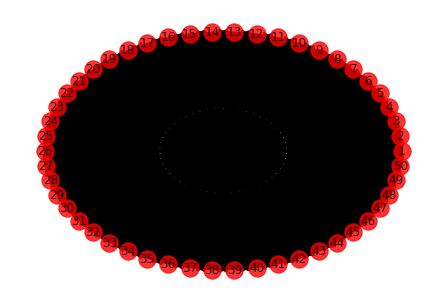

In [3]:
#Presenting the entire network 

F = nx.DiGraph()

F.add_edges_from(A)

pos = nx.spring_layout(F)   

nx.draw_circular(F, edge_color='black',node_shape = 'o', width=2,node_size=300,node_color='red', alpha=0.8,\
labels={node:node for node in F.nodes()})

plt.show()

### Part - 1 : Optimization Modelling (Linear Programming) 

Section - 4 # Traditional Optimization Modelling 

Academic license - for non-commercial use only - expires 2022-09-05
Using license file /Users/hgupta/gurobi.lic
The Execution Time of TPP is:  9.710265159606934 seconds

Optimal Objective Function: 1200

Optimal path:
1 -> 19
8 -> 25
17 -> 8
18 -> 17
19 -> 33
20 -> 1
25 -> 20
33 -> 45
45 -> 18



This is the Optimal Product Distribution Network


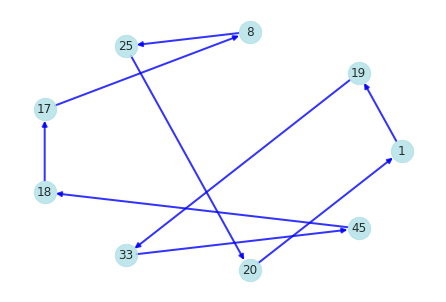

In [4]:
start = time.time()

m = Model('Traveling Purchaser Problem')

#Decision Variables for the model 
x = m.addVars(Cij.keys(), vtype=GRB.BINARY, name="x_")
y = {i:m.addVar(vtype=GRB.BINARY, name="y_"+str(i)) for i in M}
z = m.addVars(fik.keys(), vtype=GRB.CONTINUOUS, name="z_")
u = {i:m.addVar(vtype=GRB.CONTINUOUS, name="u_"+str(i)) for i in M}


#Constraints of the model 
for h in M:
    m.addConstr(x.sum(h,'*') ==  y[h])
    m.addConstr(x.sum('*',h) ==  y[h])

#Demand fulfilment constraints 
for k in P:
    m.addConstr(quicksum(z[i,k] for i in Mk[k]) == dk[k])
    for i in Mk[k]:
        m.addConstr(z[i,k] <= qik[i,k]*y[i] )  

#Travel Order constraint
for i in M:
    for j in M:
        if i!=j:
            m.addConstr(u[i] - u[j] + (len(M)+1)*x[i,j] <= (len(M)+1)-1 )

#Objective Functions
m.setObjective(quicksum(fik[i,k]*z[i,k] for k in P for i in Mk[k]) + quicksum(Cij[i,j]*x[i,j] for (i,j) in Cij.keys()) ) 

m.setParam("OutputFlag", 0)
m.update()

#Optimize the model 
m.optimize()

#Find out the time for running the algorithom by function 
execution_time = time.time() - start

print("The Execution Time of TPP is: ", execution_time, "seconds")
new_arcs = []


# Print solution
if m.status == GRB.Status.OPTIMAL:
    solution_OF= m.objVal
    solution_x = m.getAttr('x', x)
    solution_z = m.getAttr('x', z)
    solution_u = m.getAttr('x', u)
    print('\nOptimal Objective Function: %g' %solution_OF)
    print('\nOptimal path:')

    for i,j in A:
        if solution_x[i,j] > 0:
            print('%s -> %s' % (i, j))
            new_arcs.append((i,j))

print("\n\n\nThis is the Optimal Product Distribution Network")           
G = nx.DiGraph()

G.add_edges_from(new_arcs)

pos = nx.spring_layout(G)   

nx.draw_circular(G, edge_color='b',node_shape = 'o', width=2,node_size=500,node_color='powderblue', alpha=0.8,\
labels={node:node for node in G.nodes()})

plt.show()


### Part - 2 : Application of Metaheuristics (Genetic Algorithm) 

Section - 5 # Data Preprocessing for GA

In [136]:
for i in range(2, len(M)):
    for k in range(2, len(P)): 
        tu = (i,k)
        if tu not in qik.keys(): 
            qik.update({tu: 0})

Section - 6 # Function for Choosing the Market to Visit for Purchasing 

In [137]:
#Select which cities to buy the products
#availability_of_products = {(1,1): 0, (2,1): 1, (k,c): 1 or 0}
#demand_needed = {(1): 1, (2): 3, (k): K}

def create_where_to_buy(availability_product, number_of_cities, demand_needed):
    demand_needed_aux = demand_needed.copy()
    availability_product_aux =availability_product.copy()
    demand_is_met = False
    where_and_how_much_to_buy ={}
    while demand_is_met == False:
        products_still_needed = [int(product) for product in demand_needed.keys() if demand_needed_aux[product] > 0]
        for product_k in products_still_needed:
            pop=set(np.arange(number_of_cities,dtype=int))
            random_city= list(random.sample(pop,1))[0]
            if (random_city, product_k) in availability_product_aux.keys() and availability_product_aux[(random_city, product_k)] > 0:
                availability_product_aux[(random_city,product_k)] -= 1
                demand_needed_aux[product_k] -= 1
                if (product_k,random_city) in where_and_how_much_to_buy.keys(): 
                    where_and_how_much_to_buy[(random_city, product_k)] = where_and_how_much_to_buy[(random_city,product_k)] + 1
                else:
                    where_and_how_much_to_buy[(random_city, product_k)] = 1
                    
        products_still_needed = [int(product) for product in demand_needed.keys() if demand_needed_aux[product] > 0]
        if not products_still_needed:
            demand_is_met = True
   
    return where_and_how_much_to_buy, demand_needed_aux, availability_product_aux

Section - 7 # Implementing the Function to Find Out the Trvelled Markets 

In [139]:
#Select which cities to buy the products
#availability_of_products = {(1,1): 0, (2,1): 1, (k,c): 1 or 0}
#demand_needed = {(1): 1, (2): 3, (k): K}

#Number of cities 
N = len(M)
#Number of products 
K = len(P)

n = 15
availability_product = qik
demand_needed = dk
#availability_product = {(product,city): np.random.randint(10,15) for product in range(0,K) for city in range(0,N)}
#demand_needed = {(product):np.random.randint(2,6) for product in range(0,K)}
'''print(availability_product)
print("\n")
print(demand_needed)'''

where_and_how_much_to_buy, demand_needed_aux, availability_product_aux = create_where_to_buy(availability_product = availability_product, number_of_cities = N, demand_needed = demand_needed)
'''print("\n")
print(availability_product_aux)
print("\n")
print(demand_needed_aux)
print("\n")
print(where_and_how_much_to_buy)
'''
markets_to_visit = []
for market in where_and_how_much_to_buy.keys():
    if market[1] not in markets_to_visit:
        markets_to_visit.append(market[1])

print(markets_to_visit)

[3, 7, 9, 12, 14, 15, 16, 18, 20, 24, 25, 27, 29, 30, 32, 33, 39, 40, 42, 43, 44, 47, 49, 50, 2, 5, 8, 10, 13, 17, 21, 22, 28, 35, 36, 41, 48, 31, 37, 38, 46, 19, 23, 26, 34, 6, 45, 11, 4, 1]


Section - 8 # Calculating the Product Purchasing Cost 

In [140]:
cost = 0

for i,k in where_and_how_much_to_buy:
    if where_and_how_much_to_buy[i,k] > 0: 
        cost = cost + (fik[i,k]-n) * where_and_how_much_to_buy[i,k]

print(cost)

488


Section - 9 # Function for Creating Starting Population

In [141]:
def create_starting_population(size,Number_of_city): 
    
    population = []
    
    for i in range(0,size):
        population.append(create_new_member(Number_of_city))
        
    return population

Section - 10 # Function for Score Population

In [142]:
def score_population(population, City_List):  
    scores = []
    #This function will be dependednt on fitness function for calculating scores 
    for i in population:
        scores.append(fitness(i, City_List))
    return scores

Section - 11 # Function for Score Population

In [143]:
def fitness(route,City_List):
    #keeping score 0in the begining
    score=0
    for i in range(1,len(route)):
        k=int(route[i-1])
        l=int(route[i])
        #check all the scores of each routes
        score = score + Cij[k+1,l+1]        
    return score

Section - 12 # Function for creating new member of the population

In [144]:
def create_new_member(Number_of_city):

    pop=set(np.arange(Number_of_city,dtype=int))
    #creating new solutions in random in the solution space
    route=list(random.sample(pop,Number_of_city))
    
    #will return the solution route
    return route

Section - 12 # Function for crossover between parents

In [145]:
def crossover(route1,route2):

    child=[]
    childA=[]
    childB=[]
    
    
    geneA=int(random.random()* len(route1))
    geneB=int(random.random()* len(route1))
    
    start_gene=min(geneA,geneB)
    end_gene=max(geneA,geneB)
    
    for i in range(start_gene,end_gene):
        childA.append(route1[i])
        
    childB=[item for item in route1 if item not in childA]
    child=childA+childB
    
    
    
       
    return child

Section - 13 # Function for mutation

In [146]:
def mutate(route,probablity):

    route=np.array(route)
    for swaping_p in range(len(route)):
        #proablity of mutation 
        if(random.random() < probablity):
            swapedWith = np.random.randint(0,len(route))
            
            temp1=route[swaping_p]
            
            temp2=route[swapedWith]
            route[swapedWith]=temp1
            route[swaping_p]=temp2
    #route after mutation
    return route
    

Section - 14 # Function for Selection of route 

In [147]:
def selection(popRanked, eliteSize):
    selectionResults=[]
    result=[]
    for i in popRanked:
        result.append(i[0])
    for i in range(0,eliteSize):
        selectionResults.append(result[i])
    
    return selectionResults

Section - 15 # Function for ranking the route

In [148]:
def rankRoutes(population,City_List):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = fitness(population[i],City_List)
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = False)

Section - 16 # Function for breed population 

In [149]:
def breedPopulation(mating_pool):
    children=[]
    for i in range(len(mating_pool)-1):
            children.append(crossover(mating_pool[i],mating_pool[i+1]))
    return children

Section - 17 # Function for creating new genaration

In [150]:
def mutatePopulation(children,mutation_rate):
    new_generation=[]
    for i in children:
        muated_child=mutate(i,mutation_rate)
        new_generation.append(muated_child)
    return new_generation

Section - 18 # Function for creating mating 

In [151]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Section - 19 # Function for finding next generation 

In [152]:
def next_generation(City_List,current_population,mutation_rate,elite_size):
    population_rank=rankRoutes(current_population,City_List)

    selection_result=selection(population_rank,elite_size)
    
    mating_pool=matingPool(current_population,selection_result)
    
    children=breedPopulation(mating_pool)
    
    next_generation=mutatePopulation(children,mutation_rate)

    return next_generation

Section - 20 # Function for applying genetic algorithm 

In [163]:
def genetic_algorithm(City_List,size_population=1000,elite_size=75,mutation_Rate=0.01,generation=2000):
    '''size_population = 1000(default) Size of population
        elite_size = 75 (default) No. of best route to choose
        mutation_Rate = 0.05 (default) probablity of Mutation rate [0,1]
        generation = 2000 (default) No. of generation  
    '''
    pop=[]
    progress = []
    
    Number_of_cities=len(City_List)
    
    population=create_starting_population(size_population,Number_of_cities)
    progress.append(rankRoutes(population,City_List)[0][1]+cost)
    #print(f"initial route distance {progress[0]}")
    #print(f"initial total cost {population[0] + cost}")
    for i in range(0,generation):
        pop = next_generation(City_List,population,mutation_Rate,elite_size)
        progress.append(rankRoutes(pop,City_List)[0][1]+cost)
    
    
    rank_=rankRoutes(pop,City_List)[0]
    
    print(f"Best Route :{pop[rank_[0]]} ")
    print(f"Best route total cost {rank_[1] + cost}")
    plt.plot(progress)
    plt.ylabel('Total cost')
    plt.xlabel('Generation')
    plt.show()
    
    return rank_, pop

Best Route :[16 17 18 27 29 34 19  9 11 39 45 26  7 41  1  0  5 42 25 22 21  8 28  6
 20 38 47 33 13  3 43 46 37 35 30 48 15 49 40 44 14  4 32 12 24 36 23 31
 10  2] 
Best route total cost 1484


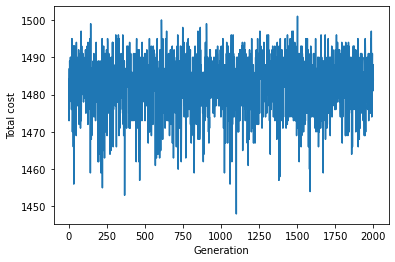

In [164]:
rank_,pop=genetic_algorithm(City_List=markets_to_visit)

In [155]:
lin = np.array(pop[rank_[0]]) + 1 

In [156]:
links = []
for i in range(len(lin)-1): 
    #print(i)
    links.append((lin[i], lin[i+1]))
links.append((lin[0], lin[-1]))               
print(links)

[(3, 49), (49, 20), (20, 43), (43, 32), (32, 48), (48, 21), (21, 1), (1, 14), (14, 37), (37, 6), (6, 30), (30, 36), (36, 39), (39, 11), (11, 25), (25, 15), (15, 27), (27, 23), (23, 13), (13, 33), (33, 47), (47, 17), (17, 29), (29, 44), (44, 19), (19, 26), (26, 2), (2, 12), (12, 50), (50, 24), (24, 8), (8, 7), (7, 45), (45, 38), (38, 18), (18, 35), (35, 42), (42, 9), (9, 5), (5, 34), (34, 16), (16, 41), (41, 46), (46, 28), (28, 40), (40, 31), (31, 4), (4, 10), (10, 22), (3, 22)]





This is the Optimal Product Distribution Network


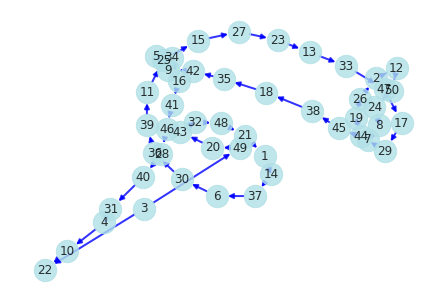

In [158]:
print("\n\n\nThis is the Optimal Product Distribution Network")           
G = nx.DiGraph()

G.add_edges_from(links)

pos = nx.spring_layout(G)   

nx.draw(G, edge_color='b',node_shape = 'o', width=2,node_size=500,node_color='powderblue', alpha=0.8,\
labels={node:node for node in G.nodes()})

plt.show()

#### Reference - 
1. http://jriera.webs.ull.es/TPP.htm
2. https://towardsdatascience.com/introduction-to-genetic-algorithms-including-example-code-e396e98d8bf3 
3. https://machinelearningmastery.com/simple-genetic-algorithm-from-scratch-in-python/
4. https://crescointl.com/2021/03/17/using-a-genetic-algorithm-for-traveling-salesman-problem-in-python/ 
5. https://medium.com/thecyphy/travelling-salesman-problem-using-genetic-algorithm-130ab957f165 
